# Chamfer Approximation

In this notebook we attempt to approximate the chamfer similarity directly. First, we build an LSH forest for each document and query to find the closest matching vector before taking the dot product. Second, we use an LSH forest that encorporates multiple documents together and perform this same estimation.

Calculate Chamfer Directly:
- Extremely fast in practice
- $O(n^2qd)$. 

Simple LSH Forest
- Slowest in practice
- $O(nq(lk_m + ad + a log(a)))$

The multi-document Forest
- Slightly faster than simple approach above
- $O(nq(lk_m + ad + a log(a)))$

In [4]:
import numpy as np
import pytest
import time

def chamfer(queries: np.ndarray, vectors: np.ndarray):
        """Takes two sets of vectors and calculates chamfer
        
        O()
        """

        # (n, m) matrix of all the pairwise dot products
        dot_products = queries @ vectors.T

        # sum the max value for each query (row)
        chamfer = np.sum(np.max(dot_products, axis=1))
        return chamfer

def timed_score(score_fn, query_vecs, doc_vecs, **kwargs):
    n_q, n_d = len(query_vecs), len(doc_vecs)
    print(f"→ Running {score_fn.__name__} on {n_q} query vectors vs {n_d} doc vectors...")

    start = time.perf_counter()
    score = score_fn(query_vecs, doc_vecs, **kwargs)
    end = time.perf_counter()

    print(f"Time taken: {end - start:.6f} seconds")
    print(f"Vector comparisons (est.): {n_q * n_d:,}\n")

    return score

# Quick test
A = np.array([[1, 0]], dtype=float)
B = np.array([[1, 0], [np.sqrt(.5), np.sqrt(.5)]], dtype=float)
C = np.array([[1, 0], [0, 1], [np.sqrt(.1), np.sqrt(.9)], [np.sqrt(.5), np.sqrt(.5)]], dtype=float)

assert timed_score(chamfer, A, B) == pytest.approx(1.0)
assert timed_score(chamfer, B, A) == pytest.approx(1 + np.sqrt(.5))
assert timed_score(chamfer, B, C) == pytest.approx(2)
assert timed_score(chamfer, B, B) == pytest.approx(2)
assert timed_score(chamfer, C, C) == pytest.approx(4)

→ Running chamfer on 1 query vectors vs 2 doc vectors...
Time taken: 0.000099 seconds
Vector comparisons (est.): 2

→ Running chamfer on 2 query vectors vs 1 doc vectors...
Time taken: 0.000039 seconds
Vector comparisons (est.): 2

→ Running chamfer on 2 query vectors vs 4 doc vectors...
Time taken: 0.000044 seconds
Vector comparisons (est.): 8

→ Running chamfer on 2 query vectors vs 2 doc vectors...
Time taken: 0.000040 seconds
Vector comparisons (est.): 4

→ Running chamfer on 4 query vectors vs 4 doc vectors...
Time taken: 0.000036 seconds
Vector comparisons (est.): 16



In [ ]:
import matplotlib.pyplot as plt
import sys
import os
sys.path.append(os.path.abspath("../src"))
from shared.lsh_forest import LSHForest, MultiDocLSHForest, BitSamplingLSH
import time
import random

def timed_best(best_fn, forest, a):
    start = time.perf_counter()
    score, doc = best_fn(forest, a)
    end = time.perf_counter()

    n_queries = queries.shape[0]
    total_candidates = a * n_queries
    print(f"{best_fn.__name__} took {end - start:.4f} sec, "
          f"{total_candidates:,} vector comparisons (approx)\n")
    return score, doc

def plot(x, y, xlabel):
    plt.figure()
    plt.plot(x, y, marker='o')
    plt.grid(True)
    plt.xlabel(xlabel)
    plt.ylabel('Similarity Score')
    plt.title(f'Convergence of LSH approximation as {xlabel} grows')
    plt.show()

def plot_similarity_heatmap(query_vecs, doc_vecs, title="Similarity Heatmap"):
    sim_matrix = np.dot(query_vecs, doc_vecs.T)  # shape (q, m)

    gamma = 2  # adjust for more/less suppression
    transformed = np.sign(sim_matrix) * (np.abs(sim_matrix) ** gamma)

    plt.figure(figsize=(8, 6))
    cmap = plt.get_cmap("bwr")
    plt.imshow(transformed, aspect='auto', cmap=cmap, vmin=-1, vmax=1)
    plt.colorbar(label=f'Power-Law Dot Product (γ={gamma})')
    plt.xlabel("Document Vector Index")
    plt.ylabel("Query Vector Index")
    plt.title(title)
    plt.tight_layout()
    plt.show()

def experiment(variable, values, defaults, build, best, topk=False):
    sims, docs = [], []
    for value in values:
        parameters = defaults.copy()
        parameters[variable] = value
        forest = build(parameters['l'], parameters['k'], parameters['km'])

        if topk:
            top_docs = best(forest, parameters['a'], k=5)
            sim, doc = top_docs[0]  # use top-1 for analysis
        else:
            sim, doc = best(forest, parameters['a'])

        sims.append(sim)
        docs.append(doc)

        if topk:
            print(f"{variable} = {value} → Top 5 docs: {top_docs}")

    print(f"Finished experiment: {variable}")
    return sims, docs


def simple_approximate_topk(forests: list[LSHForest], a, k=5):
    matches = np.empty((n, q, d), dtype=np.float32)

    for document, forest in enumerate(forests):
        for i, query in enumerate(queries):
            idx = forest.query(query, a, dist=distance)[0][0]
            matches[document, i] = forest.data[idx]

    sims = np.tensordot(matches, queries, axes=([1, 2], [0, 1]))  # shape: (n,)
    ranked_doc_indices = np.argsort(sims)[::-1]  # descending

    topk_docs = [(int(i), float(sims[i])) for i in ranked_doc_indices[:k]]
    return topk_docs

def multidoc_approximate_best(forest: MultiDocLSHForest, a):
        matches = np.empty((n, q, d), dtype=np.float32)
        for i, query in enumerate(queries):
                results = forest.query(query, a, dist=distance)
                for document, result in enumerate(results):
                        idx, _ = result[0]
                        matches[document, i] = forest.data[document][idx]
        sims = np.tensordot(matches, queries, axes=([1, 2], [0, 1]))
        best_doc = int(np.argmax(sims))
        return float(sims[best_doc]), best_doc


n = 1000                                 # number of documents
q = 25                                  # vectors per query
m = 64                                  # vectors per document
d = 16                                  # dimension per vector
l = 10                                  # trees per forest
k = 20                                  # pivots to keep per node in tree
km = 64                                 # max depth of each tree
a = 14                                  # number of neighbors to retrieve per query
rng = np.random.default_rng(42)
distance = lambda a, b: -np.dot(a, b)
defaults = dict(l=l, k=k, km=km, a=a)

experiments = {
        'l':  [1, 4, 8, 16, 32],
        'k':  [4, 8, 16, 32, 64],
        'km': [16, 32, 64, 128, 256],
        'a':  [1, 4, 8, 16, 32]
}

# Create a base document
base_doc = rng.normal(size=(m, d)).astype(np.float32)
base_doc /= np.linalg.norm(base_doc, axis=-1, keepdims=True)

# Query = a noisy subset of the base document (with reordering and dropout)
query_indices = rng.choice(m, size=q, replace=False)
# queries = base_doc[query_indices] + 0.01 * rng.normal(size=(q, d))  # small noise
queries = base_doc[query_indices]  # no noise
queries /= np.linalg.norm(queries, axis=-1, keepdims=True)

def make_noisy_doc(base_doc, noise_scale):
    noise = rng.normal(size=base_doc.shape).astype(np.float32)
    corrupted = base_doc + noise_scale * noise
    corrupted /= np.linalg.norm(corrupted, axis=-1, keepdims=True)
    return corrupted

# Insert the base_doc as the first "perfect" match
vectors = np.empty((n, m, d), dtype=np.float32)
vectors[0] = base_doc

# Gradually increasing noise
max_noise = 1.0
for i in range(1, n):
    alpha = i / (n - 1)  # smoothly ramps from 0 to 1
    noise_scale = alpha * max_noise
    vectors[i] = make_noisy_doc(base_doc, noise_scale)

# Normalize
base_doc /= np.linalg.norm(base_doc, axis=-1, keepdims=True)
queries /= np.linalg.norm(queries, axis=-1, keepdims=True)

# Constructors for each forest type
def build_simple_lsh(l, k, km):
    def make_lsh_instances(seed_offset=123):
        return [
            BitSamplingLSH(d, seed=seed_offset + i) for i in range(l)
        ]

    forests = []
    for doc_id in range(n):
        lsh_instances = make_lsh_instances(seed_offset=1000 * doc_id)
        forest = LSHForest.from_lsh_instances(lsh_instances, k, km)
        forest.batch_insert(vectors[doc_id])
        forests.append(forest)
    return forests

def build_multidoc_lsh(l, k, km):
        multi_doc_forest = MultiDocLSHForest(BitSamplingLSH(d), l, k, km)
        multi_doc_forest.batch_insert(vectors)
        return multi_doc_forest

# Baseline
best = (0, 0)
for document, doc_vecs in enumerate(vectors):
        sim = chamfer(queries, doc_vecs)
        if sim >= best[0]:
                best = (float(sim), document)
print(best)




(25.0, 0)


l = 1 → Top 5 docs: [(111, 14.358931541442871), (209, 14.316876411437988), (86, 14.262544631958008), (81, 14.184280395507812), (41, 14.179022789001465)]
l = 4 → Top 5 docs: [(111, 14.358034133911133), (209, 14.317094802856445), (86, 14.262592315673828), (81, 14.184268951416016), (41, 14.178360939025879)]
l = 8 → Top 5 docs: [(111, 14.359010696411133), (209, 14.316940307617188), (86, 14.263344764709473), (81, 14.183283805847168), (41, 14.178248405456543)]
l = 16 → Top 5 docs: [(111, 14.35757064819336), (209, 14.318227767944336), (86, 14.262252807617188), (81, 14.184907913208008), (41, 14.178863525390625)]
l = 32 → Top 5 docs: [(111, 14.359253883361816), (209, 14.31787395477295), (86, 14.262300491333008), (81, 14.184067726135254), (41, 14.179685592651367)]
Finished experiment: l


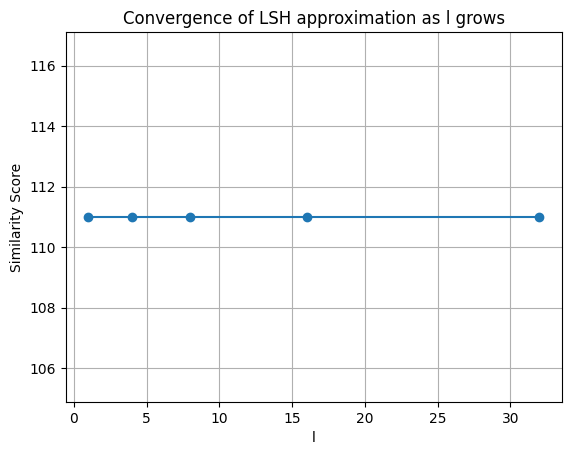

Best l = 1 → doc #14.358931541442871


IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [ ]:
# Evaluate single-doc
results = {}
for var, vals in experiments.items():
    sims, docs = experiment(var, vals, defaults, build_simple_lsh, simple_approximate_topk, topk=True)
    results[var] = (sims, docs)
    plot(experiments[var], sims, xlabel=f'{var}')
    
    # Pick the best result and visualize
    best_index = int(np.argmax(sims))
    best_doc_index = docs[best_index][0]
    print(f"Best {var} = {vals[best_index]} → doc #{best_doc_index}")
    plot_similarity_heatmap(queries, vectors[best_doc_index], title=f"{var}: Query vs. Doc {best_doc_index}")
    plot_similarity_heatmap(queries, vectors[999], "Query vs. Doc 999 (Most Random)")

    sims = [chamfer(queries, doc) for doc in vectors]
    plt.plot(sims)
    plt.xlabel("Document ID")
    plt.ylabel("Chamfer Similarity")
    plt.title("True similarity vs. document index")
    plt.grid(True)
    plt.show()


In [ ]:

# Evaluate multi-doc
results = {var: experiment(var, vals, defaults, build_multidoc_lsh, multidoc_approximate_best) for var, vals in experiments.items()}
plot(experiments['l'],  results['l'][0],  'number of trees (l)')
plot(experiments['k'],  results['k'][0],  'pivots per node (k)')
plot(experiments['km'], results['km'][0], 'tree depth (km)')
plot(experiments['a'],  results['a'][0],  'neighbours retrieved (a)')
